In [9]:
from data_provider import DataModel
dm = DataModel()
dm.read_from_csvs("../../xcels",["master0.csv","master1.csv"])

In [10]:
df = dm.get(dm.TA_SYMBOLS[0],"1390-01-01")

2020-01-01 10:25:36.002 | DEBUG    | data_provider:get:171 - symbol is not scaled: خپارس
2020-01-01 10:25:36.006 | DEBUG    | data_provider:adjust_and_log:57 - calculating scale
2020-01-01 10:25:36.029 | DEBUG    | data_provider:adjust_and_log:59 - adding adjust
2020-01-01 10:25:36.031 | DEBUG    | data_provider:add_adjust:28 - new part len is 3459, shape: (3459,)
2020-01-01 10:25:36.065 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2009-06-08 00:00:00
2020-01-01 10:25:36.075 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2010-07-05 00:00:00
2020-01-01 10:25:36.084 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2011-07-05 00:00:00
2020-01-01 10:25:36.094 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2012-06-23 00:00:00
2020-01-01 10:25:36.104 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2014-05-26 00:00:00
2020-01-01 10:25:36.113 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2016-11-15 00:00:00
2020-01-01 10:2

In [172]:
df.columns

Index(['symbol', 'name', 'amount', 'volume', 'value', 'lastday', 'open',
       'close', 'last-change', 'last-percent', 'ending', 'ending-change',
       'ending-percent', 'min', 'max', 'year', 'month', 'day', 'diff_min_max',
       'diff_open', 'adj_min', 'adj_max', 'adj_close', 'adj_open',
       'adj_ending', 'log_adj_open', 'log_adj_close', 'log_adj_ending',
       'log_adj_min', 'log_adj_max', 'adj_scale'],
      dtype='object')

In [72]:
# %%writefile ta_module.py


import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
from math import pi
import math
import matplotlib.pyplot as plt

accepted_error=0.02

#########################################################################
#########################################################################
#########################################################################
#########################################################################


def find_supports(df,minimum_touch=3):
    stocko=df["log_adj_open"].tolist()
    stockc=df["log_adj_close"].tolist()
    dates=df.index # for converting startm s to real date .... startm and stopm s are some indexes of stoko array
    
    lows=[]
    lows_price=[]
    for j in range(len(stocko)): 
        minimum=min(stocko[j],stockc[j])
        if ( (j >10) and (j+10 < len(stocko)) ):
            if (minimum<=min(stocko[j-10:j+10]) and minimum<=min(stockc[j-10:j+10])):
                lows.append(j)
                lows_price.append(minimum)

        #finding the best lines 
    # cnt = numbers of line segments
    cnt=0
    # start and stop[cnt] = start poit in x axes and stop point for each line segments
    startm=[]
    stopm=[]
    checkedpoint=[]
    lastpoint=0
    count_max=0
    a_maxm=[]
    b_maxm=[]
    xarr=lows
    yarr=lows_price
    max_last=0
    # all tangents from 0.04 to -0.04 digree . i will break them in to 1000 pieces this is too short because we're using log numbers
    digree=np.linspace(-0.05,0.05,1000)
    coefs=np.tan(digree*pi / 180)


    for point in range(len(xarr)) :
        max_last=0  
        count_max=0
    #  x and y are the ones of this point
        x=xarr[point]
        y=yarr[point]
    # for this point i am breaking the line into 100 pieces
#         b_fakes=np.linspace(y-(y*accepted_error),y+(y*accepted_error),100)
        b_fakes=np.linspace(math.log10((10**y)-((10**y)*accepted_error)),math.log10((10**y)+((10**y)*accepted_error)),100)
        for b in b_fakes:
            for a in coefs:
                count=0
                for p in range(point+1,len(xarr)):
                #  x_ and y_ s are for all next points in new dimensions !!
                    x_ = xarr[p]-x
                    y_ = yarr[p]
                    if(x_*a+b>=math.log10((10**y_)-((10**y_)*accepted_error))) and (x_*a+b<=math.log10((10**y_)+((10**y_)*accepted_error))):
#                     if((x_*a+b>=y_-(y_*accepted_error)) and (x_*a+b<=y_+(y_*accepted_error))):
                        count+=1
                        lastpoint=xarr[p]
                    elif (math.log10((10**y_)+((10**y_)*accepted_error)) < x_*a+b ): 
#                     elif (y_+(y_*accepted_error) < x_*a+b ):
                        break
                if(count>count_max):
                    max_last=lastpoint # max last baraye save kardane lastpointi ke niaz darime . maxof_a , b ham hamintor
                    count_max=count
                    maxof_a=a
                    maxof_b=b
                lastpoint=0

    #   if this start point include a line that touch three points: count_max are the number of other points (=2) . so it should be >= minimum touch -1
        if(count_max>=minimum_touch-1):
            repetitious=False
            a_in_radian=math.atan(maxof_a)
            a_in_degree=math.degrees(a_in_radian)
            for cnt in range(len(a_maxm)):
                if((math.degrees(math.atan(a_maxm[cnt])) >= a_in_degree -0.004) and 
                   (math.degrees(math.atan(a_maxm[cnt])) <= a_in_degree +0.004) and
                   (stopm[cnt]==max_last)):
                    repetitious=True

            if(not(repetitious)):
                a_maxm.append(maxof_a)
                b_maxm.append(maxof_a*(-x)+maxof_b)
                startm.append(x)
                stopm.append(max_last)
    
#     dates[startm]  because we wanna return exact date
    return startm,stopm,a_maxm,b_maxm,lows


#########################################################################
#########################################################################
#########################################################################
#########################################################################

def find_resistances(df,minimum_touch=3):
    stocko=df["adj_open"].tolist()
    stockc=df["adj_close"].tolist()
    dates=df.index # for converting startm s to real date .... startm and stopm s are some indexes of stoko array
    

    highs=[]
    highs_price=[]
    for j in range(len(stocko)): 
        maximum=max(stocko[j],stockc[j])
        if ( (j >10) and (j+10 < len(stocko)) ):
            if (maximum>=max(stocko[j-10:j+10]) and maximum>=max(stockc[j-10:j+10])):
                highs.append(j)
                highs_price.append(maximum)

    #finding the best lines 
    # cnt = numbers of line segments
    cnt=0
    # start and stop[cnt] = start poit in x axes and stop point for each line segments
    start=[]
    stop=[]
    checkedpoint=[]
    lastpoint=0
    count_max=0
    a_max = []
    b_max= []
    xarr = highs
    yarr = highs_price
    max_last = 0
    # all tangents from 80 to -80 digree . i will break them in to 1000 pieces
    digree=np.linspace(-80,80,1000)
    digrees=np.tan(digree*pi / 180)


    for point in range(len(xarr)) :
        max_last=0
        count_max=0
    #  x and y are the ones of this point
        x=xarr[point]
        y=yarr[point]
    # for this point i am breaking the line into 100 pieces
        b_fakes=np.linspace(y-15,y+15,100)  
        for b in b_fakes:
            for a in digrees:
                count=0
                for p in range(point+1,len(xarr)):
                #  x_ and y_ s are for all next points in new dimensions !!
                    x_ = xarr[p]-x
                    y_ = yarr[p]
                    if((x_*a+b>=y_-15) and (x_*a+b<=y_+15)):
                        count+=1
                        lastpoint=xarr[p]
                    elif (y_-15 > x_*a+b ):
                        break
                if(count>count_max):
                    max_last=lastpoint # max last baraye save kardane lastpointi ke niaz darime . maxof_a , b ham hamintor
                    count_max=count
                    maxof_a=a
                    maxof_b=b
                lastpoint=0

    #   if this start point include a line that touch three points: count_max are the number of other points .
        if(count_max>=minimum_touch-1):
            repetitious=False
            a_in_radian=math.atan(maxof_a)
            a_in_degree=math.degrees(a_in_radian)
            for cnt in range(len(a_max)):
                if((math.degrees(math.atan(a_max[cnt])) >= a_in_degree -5) and 
                   (math.degrees(math.atan(a_max[cnt])) <= a_in_degree +5) and
                   (stop[cnt]==max_last)):
                    repetitious=True

            if(not(repetitious)):
                a_max.append(maxof_a)
                b_max.append(maxof_a*(-x)+maxof_b)
                start.append(x)
                stop.append(max_last)
    #     dates[startm]  because we wanna return exact date
#     start_dates=df.iloc[start].index
    return start,stop,a_max,b_max

In [2]:
from data_provider import DataModel
dm = DataModel()
dm.read_from_csvs("../../xcels",["master0.csv","master1.csv"])
df = dm.get(dm.TA_SYMBOLS[0],"1395-01-01","1396-01-01")

2020-01-10 10:41:05.781 | DEBUG    | data_provider:get:172 - symbol is not scaled: خپارس
2020-01-10 10:41:05.796 | DEBUG    | data_provider:adjust_and_log:57 - start adjust and log for خپارس
2020-01-10 10:41:05.798 | DEBUG    | data_provider:adjust_and_log:58 - calculating scale
2020-01-10 10:41:05.841 | DEBUG    | data_provider:adjust_and_log:60 - adding adjust
2020-01-10 10:41:05.843 | DEBUG    | data_provider:add_adjust:28 - new part len is 3459, shape: (3459,)
2020-01-10 10:41:05.877 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2009-06-08 00:00:00
2020-01-10 10:41:05.889 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2010-07-05 00:00:00
2020-01-10 10:41:05.896 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2011-07-05 00:00:00
2020-01-10 10:41:05.903 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2012-06-23 00:00:00
2020-01-10 10:41:05.911 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2014-05-26 00:00:00
2020-01-10 10:41

In [45]:
dm.TA_SYMBOLS[0]

'خپارس'

In [73]:
start,stop,a,b,lows=find_supports(df)

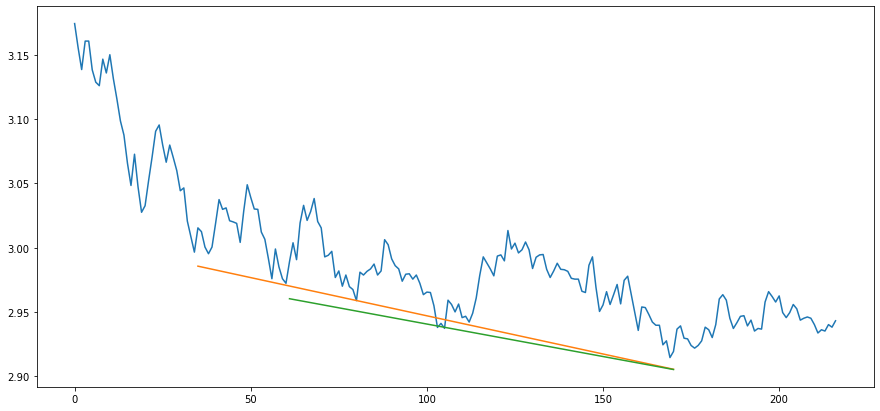

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(np.arange(len(df)),df.log_adj_close)
for i in range(len(start)):
    
    plt.plot([start[i],stop[i]],[a[i]*start[i]+b[i],a[i]*stop[i]+b[i]])

In [19]:
a_in_radian=math.atan(8.735e-7)
a_in_degree=math.degrees(a_in_radian)
a_in_degree

5.004786340466468e-05

In [41]:
math.log10(100)

2.0

In [23]:
a

[-0.0008726648475212713,
 -0.0008639294592936493,
 -0.0004883078725776307,
 -0.0002804057580449762,
 0.0007468752692325392]